<h1><b>Image Compression using Unsupervised Learning</b></h1>
<h4>Editor: Daniel Wang</h4>

Unsupervised Learning is extremely suitable for image compression tasks, for the label can simply refer to its pixel values. Common image compression techniques include K-means clustering, PCA, etc. In this project, we will use a sample image from the [ImageNet](http://image-net.org/) dataset. Let's take an elephant image as an example:

<h2><b><u>Data Exploration</u></b></h2>

(466, 700, 3)
max=255, min=0, type=uint8


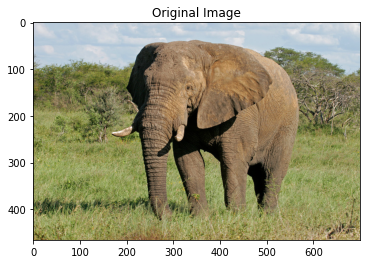

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests

url = "https://raw.githubusercontent.com/larq/zoo/master/tests/fixtures/elephant.jpg"
img = requests.get(url, stream=True).raw
img = plt.imread(img, format="JPEG")
print(img.shape)
print("max={}, min={}, type={}".format(np.max(img), np.min(img), img.dtype))

plt.imshow(img)
plt.title("Original Image")
plt.show()

This image is composed of 3 channels (i.e. RGB) and has a resolution of 466x700. Each 3-dimensional pixel has integer values range from 0 to 255, and each channel is stored in 8 bytes (uint8).

Next, let's try to compress such an image by some unsupervised learning methods. For a fair comparison, let's define the reconstruction loss to measure the performance of models:

In [2]:
def rmse(arr1, arr2):
  return np.sqrt(np.mean(np.square(arr1-arr2)))

Here, we define the Root Mean Square Error as our evaluation metric.

<h2><b><u>Method 1: K-means Clustering</u></b></h2>

K-means Clustering method tries to find K centroids and assign each data point to a certain centroid ID. In this example, our data point is in 3-dimensional space (since we consider a color image). Therefore, K-means Clustering will find K centroids and assign each pixel value to a certain centroid value.

Let's first define the K-means Clustering function:

In [ ]:
from sklearn.cluster import KMeans

def image_cluster(img, k):
  img_flat = img.reshape(-1, 3)
  kmeans = KMeans(n_clusters=k, random_state=0).fit(img_flat)
  result = img_flat.copy()

  for i in np.unique(kmeans.labels_):
    result[kmeans.labels_==i,:] = kmeans.cluster_centers_[i]
        
  return result.reshape(img.shape), kmeans.inertia_

To pick an optimal K value, we shall find the elbow point from the inertia curve. Let's try different K value within a maximum of 20:

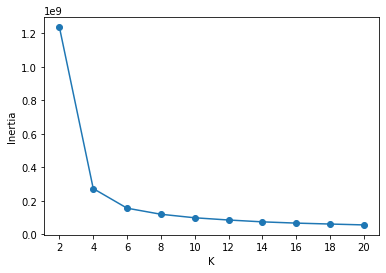

In [ ]:
k_vals = list(range(2, 21, 2))

img_kmeans = []
inertia = []
for k in k_vals:
  img2, inert = image_cluster(img, k)
  img_kmeans.append(img2)
  inertia.append(inert)

plt.plot(k_vals, inertia)
plt.scatter(k_vals, inertia)
plt.xticks(np.arange(2, 21, 2))
plt.xlabel("K")
plt.ylabel("Inertia");

As we can see, the inertia significantly drops when K=4, and drops more when K=6. After K=6, the inertia becomes smaller, but the improvement is not very obvious.

To explore their performances, let's see the reconstruction result when K=[2,4,6]:

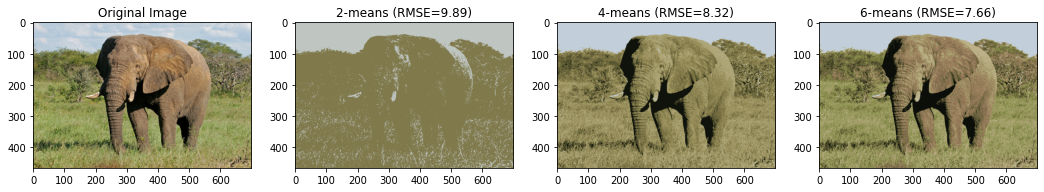

In [ ]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18, 8)
axes[0].imshow(img)
axes[0].set_title("Original Image")

for i in [2, 4, 6]:
  axes[int(i/2)].imshow(img_kmeans[i-2])
  axes[int(i/2)].set_title("{}-means (RMSE={:.2f})".format(i, rmse(img, img_kmeans[i-2])))

plt.show()

When K=2, there are only 2 different pixel values, so the image becomes monotonic. However, we can still observe an outline of the elephant.

When K=4, the reconstructed image becomes closer to the original one, and when K=6, the elephant is not rendered monotonically anymore. 

The RMSE metric measures the performance of reconstruction, and as K becomes larger, the error becomes smaller. In this example, I assume that K=6 is the sweet point in the inertia curve, and set the output as the default outcome from K-means.

**Note that the inertia is different from the reconstruction error, for inertia stands for the distance between each reconstructed pixel to the corresponded centroid, and reconstruction error stands for the distance between each reconstructed pixel to the pixel in the original image.**

So far, we've seen reconstruction errors given by a certain K. However, the value of the K-means is that it can represent a given image in only a few colors. In K=6 settings, we can reduce the color representation from this image significantly, from 86468 distinct values to only 6 values! 

In [ ]:
orig_len = len(np.unique(img.reshape(-1, 3), axis=0))
comp_len = len(np.unique(img_kmeans[2].reshape(-1, 3), axis=0))
print("{} -> {} ({:.2f}%)".format(orig_len, comp_len, comp_len/orig_len*100))

86468 -> 6 (0.01%)


Therefore, K-means can effectively compress the image into a much smaller color space, which makes the data be stored without much loading.

<h2><b><u>Method 2: PCA (Principle Component Analysis)</u></b></h2>

In addition to the K-means Clustering method, another common approach to compress an image is the PCA technique.

**However, most PCA methods can only work for images with many observations**, since common approaches involve reducing the number of the flattened image features. [For example](https://towardsdatascience.com/image-compression-using-principal-component-analysis-pca-253f26740a9f), for the MNIST dataset with 60000 observations and 784 features (i.e. 28x28 image grid), a PCA with *n_components=10* will reduce the 784 feature space into 10-dimensional feature space, and the 10 principle components should rely on the coordinates of 60000 observations (in 784D). **Unfortunately, we have only a single observation here**. How could we still apply PCA to such a case without reference to any other images?

Here I come up with a solution:

1. Separate the image into red, green and blue channels.
2. For each channel, take **each row** as the feature, so we can have 466 observations (image height) in 700-dimensional space (image width).
3. For each channel, do PCA over its 700-D features.

To explain this, let's check my code directly. First, let's separate the image into 3 different channels:


In [3]:
r, g, b = [img[:,:,i] for i in range(3)]

Each channel represent red, green and blue, respectively. Then, for each channel we conduct the PCA:

In [4]:
from sklearn.decomposition import PCA

pca = PCA(random_state=0)

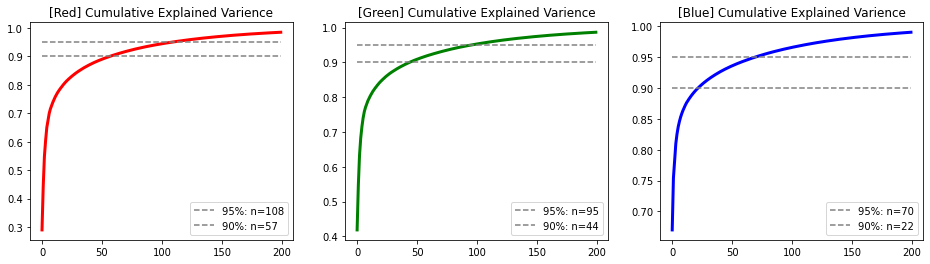

In [5]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(16, 4)
for idx, (name, channel) in enumerate(zip(["Red", "Green", "Blue"], [r, g, b])):
  result = pca.fit_transform(channel)
  cumsum = np.cumsum(pca.explained_variance_ratio_)[:200] # cumulative sum

  axes[idx].plot(cumsum, color=name, lw=3)
  axes[idx].plot(range(200), [0.95]*200, color="gray", ls="--", label="95%: n={}".format(np.argmax(cumsum>0.95)))
  axes[idx].plot(range(200), [0.90]*200, color="gray", ls="--", label="90%: n={}".format(np.argmax(cumsum>0.9)))
  axes[idx].legend(loc="lower right")
  axes[idx].set_title("[{}] Cumulative Explained Varience".format(name))

As we can see, different *n_components* has a different number of cumulative explained variance. Here the cumulative explained variance means how the reduced feature space (i.e. Eigenvectors with top-N values) can represent the overall variance of the original image. If the variance is larger, the reconstructed result should be more authentic.

To ensure reliability, we use 90% and 95% thresholds to choose a proper N (*n_components*). From the above figure, we observe that for the 90% explained variance, we should choose top-57 Eigenvectors for the red channel, top-44 for the green channel, and top-22 for the blue channel. The same logic can be applied to the case for 95% explained variance. 

Next, let's see how the PCA reduced the dimensionality:

Red: 326200 -> 26562 (8.14%)
Green: 326200 -> 20504 (6.29%)
Blue: 326200 -> 10252 (3.14%)


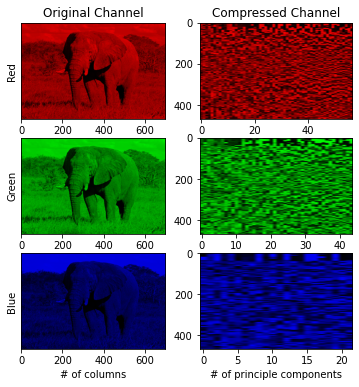

In [12]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(6, 6)

r, g, b = [img[:,:,i] for i in range(3)]
r_comp = PCA(n_components=57, random_state=0).fit_transform(r)
g_comp = PCA(n_components=44, random_state=0).fit_transform(g)
b_comp = PCA(n_components=22, random_state=0).fit_transform(b)

for idx, (name, orig, comp) in enumerate([["Red", r, r_comp], ["Green", g, g_comp], ["Blue", b, b_comp]]):
  img1 = np.zeros((orig.shape[0], orig.shape[1], 3), dtype=np.uint8)
  img1[:,:,idx] = orig
  axes[idx, 0].imshow(img1)
  axes[idx, 0].set_yticks([])
  axes[idx, 0].set_ylabel(name)

  img2 = np.zeros((comp.shape[0], comp.shape[1], 3), dtype=np.uint8)
  img2[:,:,idx] = comp
  axes[idx, 1].imshow(img2, aspect="auto")

  orig_len = orig.shape[0]*orig.shape[1]
  comp_len = comp.shape[0]*comp.shape[1]
  print("{}: {} -> {} ({:.2f}%)".format(name, orig_len, comp_len, comp_len/orig_len*100))

axes[0,0].set_title("Original Channel")
axes[0,1].set_title("Compressed Channel")
axes[2,0].set_xlabel("# of columns")
axes[2,1].set_xlabel("# of principle components")

plt.show()

Originally, the red channel has 326200 (466x700) values. After the PCA, 466 observations (rows) in 700-dimensional space are shrunk into 57-dimensional space, so only 26562 (466x57) values are needed to represent the compressed image. The same logic can be applied to the green and blue channels.

**Unlike K-means which eliminates the color-rendering capability in the RGB channels, PCA keeps the same rendering capability but reduces the number of pixels required to represent such an image.** As we can see in the red channel case, the number of pixel that needs to represent the red in the image can be reduced from 326200 to 26562, which is 8.14% of the original value.

Next, let's reconstruct the image from the PCA compression. First, we define the reconstruction function:

In [ ]:
def image_pca(img, nr, ng, nb):
  pca_r = PCA(n_components=nr, random_state=0)
  pca_g = PCA(n_components=ng, random_state=0)
  pca_b = PCA(n_components=nb, random_state=0)

  # PCA compression
  r, g, b = [img[:,:,i] for i in range(3)]
  r_comp = pca_r.fit_transform(r)
  g_comp = pca_g.fit_transform(g)
  b_comp = pca_b.fit_transform(b)

  # PCA de-compression
  r_rec = pca_r.inverse_transform(r_comp)
  g_rec = pca_g.inverse_transform(g_comp)
  b_rec = pca_b.inverse_transform(b_comp)

  # Convert to 0-255
  img_pca = [r_rec, g_rec, b_rec]
  for i in range(3): # convert to 0-255
    img_pca[i] = ((img_pca[i]-np.min(img_pca[i]))/(np.max(img_pca[i])-np.min(img_pca[i]))*255).astype(np.uint8)

  # Stack 3 channel together
  img_pca = np.stack(img_pca, axis=2)
  return img_pca

Next, let's see two PCA models with 90% and 95% explained variance respectively:

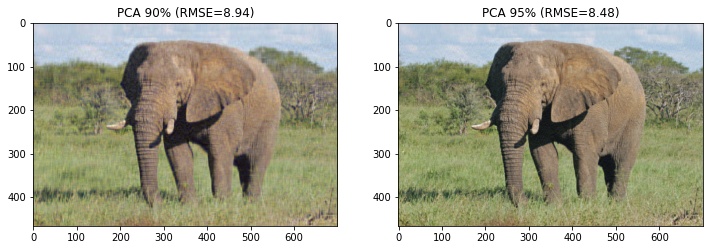

In [ ]:
img_pca90 = image_pca(img, 57, 44, 22)
img_pca95 = image_pca(img, 108, 95, 70)

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
axes[0].imshow(img_pca90)
axes[0].set_title("PCA 90% (RMSE={:.2f})".format(rmse(img, img_pca90)))
axes[1].imshow(img_pca95)
axes[1].set_title("PCA 95% (RMSE={:.2f})".format(rmse(img, img_pca95)))
plt.show()

The two outputs look very similar, yet the model with 95% explained variance yields lower RMSE. Therefore, a larger number explained variance can reconstruct an image more accurately. 

<h2><b><u>Discussion</u></b></h2>

So far, we have explored K-means Clustering and PCA for image compression and reconstruction. 

Can we tell which model is better? Let's compare their results:

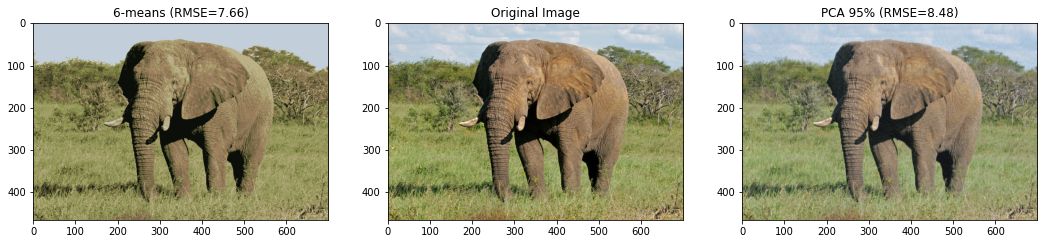

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18, 8)
axes[0].imshow(img_kmeans[4])
axes[0].set_title("6-means (RMSE={:.2f})".format(rmse(img, img_kmeans[4])))
axes[1].imshow(img)
axes[1].set_title("Original Image")
axes[2].imshow(img_pca2)
axes[2].set_title("PCA 95% (RMSE={:.2f})".format(rmse(img, img_pca2)))
plt.show()

The leftmost image is the reconstructed image from K-means, and the middle one is the original image, and the rightmost is the reconstructed image from PCA. We can see that 6-means Clustering yields lower RMSE, so it seems to have a better compression result. However, is it fair enough?

Let's look at the skies in the 3 images. The clouds are obvious in the original image and the PCA result, yet they're disappeared in the 6-mean Clustering result. In addition, the elephant in the 6-means result seems to have only 2~3 kinds of color, yet it is much more colorful in the PCA result.

To conclude, the K-means clustering yields lower RMSE and can effectively reduce the number of colors needed to represent the image, but the PCA seems to produce a more authentic image based on our observation. Perhaps, the RMSE measurement is not always the best evaluation metric to judge the fairness of reconstruction.

<h2><b><u>Conclusion</u></b></h2>

From the above experiments, we observe that:

1. Higher K value for the K-means cluster can effectively reduce the inertia and reconstruction error.
2. Higher N components for the PCA can increase the explained variance and reduce the reconstruction error.
3. K-means seems to have better performance due to a lower RMSE, but PCA seems to be more capable of reproducing a vivid picture.

<h2><b><u>Future Works</u></b></h2>

The PCA method described here is just a heuristic method invented by myself. There is no strong evidence or theory that it is reasonable to take each row as a feature.

**How can we conduct PCA more reasonably for a single image?** Another way is to split the image tightly into multiple MxN patches and then conduct PCA to reduce the dimensionality from MxN feature space to a lower-dimensional space. However, choosing the patch size is another parameter we shall tune by ourselves. We may need to put more effort to investigate the optimal PCA method for single image compression and reconstruction.